<font size=6  color=#003366> [LINMA 2472] - ALGORITHMS IN DATA SCIENCE <br><br> 
HW 2 (Part I): k-PCA for outlier detection!   </font> <br><br><br>

<font size=5  color=#003366>


<br><br>
Loïc Van Hoorebeeck [LVH]  (loic.vanhoorebeeck@uclouvain.be)<br> <br>
<div style="text-align: right"> Version 1 (2021-10-27)</div>

<br><br>
</font>

<br>

<font size=7 color=#009999> Assignment 1. PCA vs. k-PCA <br><br> for outlier detection </font> <br>

<br>
<font size=5 color=#009999> Contex </font> <br>

In this assignment, you are asked to compare PCA vs. KPCA (or k-PCA) for outlier detection. We define an outlier as any point sampled from another distribution than the one we are interested in.



<font size=5 color=#009999> Instruction </font> <br>

You should fill the jupyter notebook, and write a written report that answers the questions from the pdf file.

You have to submit <b> 3 </b> files on moodle:

    - Your jupyter notebook as .ipynb 
    - Your jupyter notebook (with all output, that is after running everything) as .pdf
    - Your written report as .pdf
    
Note that we filled the notebook such that it runs without throwing errors... But we had to sometimes write dummy lines, which implies that the plots look also dummy.

When you have to modify something in the code, you'll find a "TODO" mark.

</font>

# Packages and seed

In [28]:
#Various import

import numpy as np

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt


# When developping code, it is often easier to work with a fixed seed
np.random.seed(42)




# Q1: Data import & EDA

<font size=5 color=#009999> Q1. IMPORT THE DATA and perform EDA</font> <br>

The data consists in two arrays $X \in \mathbb{R}^{N \times 2}$ and $\mathbf{y} \in \mathbb{R}^{N}$ with

$$
y_i =
\begin{cases}
    1 & \text{ if } & \mathbf{X}_{i, *} & \text{ is an outlier,}\\
    0 & \text{ if } & \mathbf{X}_{i, *} & \text{ is a true point.}
\end{cases}
$$

with $N$ the number of samples. There are $N_o$ outliers and $N_t$ *true* point, that is $N_t$ points that are not outliers.



In [29]:
# Import of the data
X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt').astype(int)

In [30]:
len(y)

500

This dataset accounts for 500 observations with 2 explanotory variables and a binary target variable saying if the observation is an outlier or not. Because of that, a first nice thing to do is plotting the varaiables and indicate if it is an outlier. The graoh is shown below:

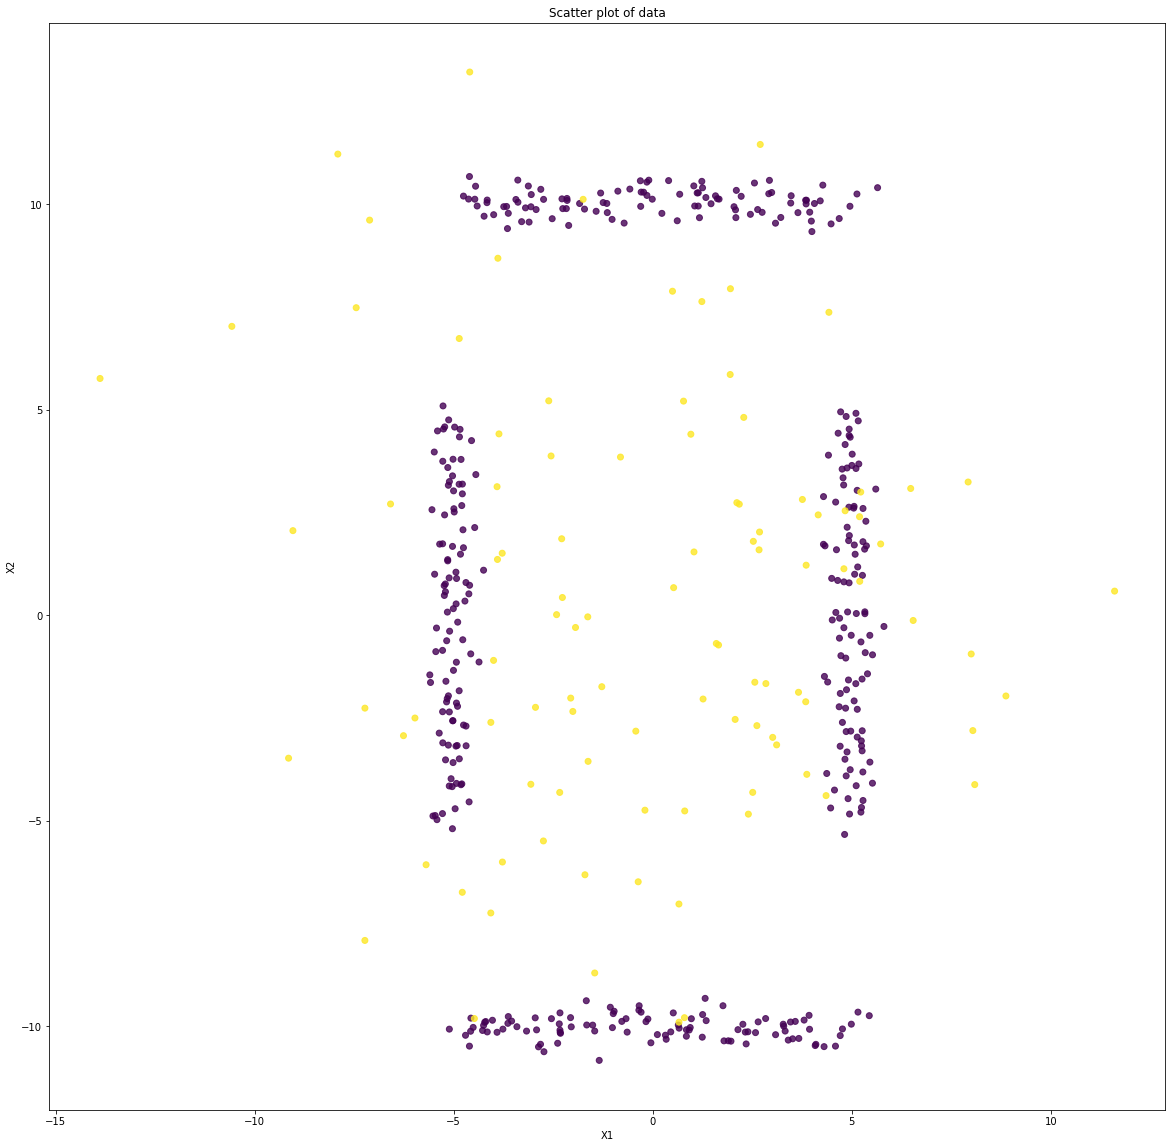

In [31]:
plt.scatter([x[0] for x in X ],[x[1] for x in X ], c=y, alpha=0.8)
plt.title("Scatter plot of data")
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Considering this structure of data, it seems clear that both explanatory varaiables are dependent. However, this particular structure is prone to show very low correlation since it only computes the linear dependence. Four regions for the "normal data" are clearly visible, two parallele and two that are orthogonal. On the other hand, the outliers seems to be randomly distributed wihin an ellipsoïde regions.

Because of this structure of data, it is clear that it would not be possible to represent the data on one axis by performing a PCA. One axis, on its own, does not allow to separate the data well. The principal axis that would be derived would be (very) parallel the X1 axis and the possible outliers to detect would be below -5 and above 5 more or less. 

Moreover, it is also clear that it is not possible to derive a proper line on this 2D that would discriminate well the data between the outliers and the "normal" data. 


In [32]:
outliers_ratio = sum(y)/len(y)
print(str(int(outliers_ratio*100)) + " % of data are outliers ")

20 % of data are outliers 


# Q2

<font size=5 color=#009999> Q2. Perform the splits </font> <br>

</font>

No need to reimplent the wheel: use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'><code>train_test_split</code></a> from sklearn to perform the splits.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle = True, test_size=0.1, 
                                                    random_state=1)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=1) # 0.3 x 0.9 = 0.27

The train and test sets must be shuffled because they were initially ordered from non outliers to outliers. 

# Q3 PCA

- PCA(), pca.fit(X) and pca.transform(X)

- PCA() est la méthode utilisée pour dire qu'on veut faire une PCA
- .fit(X) dit qu'on fite cette PCA sur telle sample
- .trasnform(X) va déterminer la valeur de X sur les axes factoriels

<font size=5 color=#009999> Q3. PCA </font> <br>
</font>

Let us implement an outlier detector using PCA. In order to make our life easier, we will create a class, denoted as <code>OutlierDetectorPCA</code>, that inherits from other classes of <code>sklearn</code>.

We implemented most of the class, but there are some parts missing...

## Class 

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

plt.rcParams['figure.figsize'] = [20, 10]


class OutlierDetectorPCA(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        """ ------------------------------------------------------------------------------
        Class constructor
        INPUT:
            - k: the number of eigenvectors that we keep, or equivalently, the size of the
                 the eigen (sub)space.
        ------------------------------------------------------------------------------ """

        self.k = k
        self.is_fitted_ = False
        #self.pca = PCA()
        self.name = 'PCA'
        self.pca = PCA() # PCA performed with 2 elements (default value = 2)
        self.tau = np.inf # infini

  
    def _get_recons_error(self, X, X_hat):
        """ ------------------------------------------------------------------------------
        Compute the reconstruction error between X and X_hat, where X_hat is the projection 
        of X onto the k-dimensional eigenspace
        INPUT: 
            - X: initial features
            - X_hat: projected features
        OUTPUT:
            - recons_error: the reconstruction error
        ------------------------------------------------------------------------------ """

        #recons_error = np.ones(X.shape[0])  # ==> Il faut une liste de n elements
        
        R_minus_k = X.shape[1] - X_hat.shape[1]
        if R_minus_k > 0:
            z = np.zeros( (len(X_hat),R_minus_k))
            X_hat = np.append(X_hat, z, axis=1)

        recons_error = np.sqrt(np.sum((X - X_hat) ** 2, axis=1))
        return recons_error

    def _predict_tau_ROC(self, X, tau):

        """ ------------------------------------------------------------------------------
        Companion function used to properly deal with the inheritance
        ------------------------------------------------------------------------------ """
        return self.predict_tau(X, tau)    
    
    
    def fit(self, X, y=None):
        """ ------------------------------------------------------------------------------
        Fit the model to the true data
        INPUT: 
            - X: train data
            - y: label data
        OUTPUT:
            - the classifier
        ------------------------------------------------------------------------------ """
        
        # We find the index of true data, i.e., not the outliers
        
        idx = np.where(y==0)[0]
        X_true = X[idx, :]
        
        # In this (supervised) context, it is better to fit PCA on the true data
        self.pca.fit(X_true) # déteminer les composantes principales en fonction deX 
        
        # X_pca stands for X expressed in the PCA basis
        X_pca = self.pca.transform(X_true) # va représenter les valeurs de X dans l'espace factoriel (pas de réduction de dimension)
        
        # X_hat_pca is the projection of X_pca on the eigenspace of dimension k
        # this is done by selecting the k first principal components
        X_hat_pca = X_pca[:, :self.k] # On prend les représentations jusque dans une dimension souhaitée. 
 
        
        recons_error = self._get_recons_error(X_pca, X_hat_pca)
        #print("10 first Reconstruction errors when fitting: ")
        #print(recons_error[:10])

        
        self.is_fitted_ = True

        """
            TODO: compute tau such that
                - No true data will be labeled as outlier in the training set
                - The True positive rate (TPR) is maximised
        """


        self.tau = max(recons_error)
        
        #print("MAX error method: "+ str(self.tau))

        self.tau_max = self.tau # Do not change this line :-)
        #print("found tau: "+str(self.tau_max))

        #print("fitting ok")
        return self


    
    def predict(self, X):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model
        INPUT: 
            - X: data
        OUTPUT:
            - y: predictions
        ------------------------------------------------------------------------------ """
        
        # Sanity checks
        check_is_fitted(self)
        X = check_array(X)
        
        y = self.predict_tau(X, self.tau)
        return y



    def get_label(self):
        label = "{name}: k={k}".format(name=self.name, k=self.k)
        return label


    def get_ROC(self, X_train, y_train):
        """ ------------------------------------------------------------------------------
        Compute the quantities needed to plot the ROC
        INPUT: 
            - X_train: data of the train set
            - y_train: label of the train set
        OUTPUT:
            - FPR: False positive rate
            - TPR: True positive rate
        ------------------------------------------------------------------------------ """
        self.score(X_train,y_train) # permet d'initialiser à zero
        
        n_tau = 100
        taus = np.linspace(0, self.tau, n_tau) # Vecteur de 0 à self.tau où il y a 100 incrémentations
        #print("tau vector:")
        #print(taus)
        
        TPR = np.empty(n_tau+1)
        FPR = np.empty(n_tau+1)
        N = np.count_nonzero(y_train) # donne le nombre d'outliers
        P = len(y_train) - N          # donne le nombre de true_values 

        for i, _t in enumerate(taus):
            x_detec = self._predict_tau_ROC(X_train, _t) # = self.predict_tau(X, tau) 
            TPR[i] = np.sum(np.logical_and(x_detec, y_train))/N
            FPR[i] = np.sum(np.logical_and(x_detec, np.logical_not(y_train)))/P

        # One last time for tau_max that may change during the prediction...
        x_detec = self._predict_tau_ROC(X_train, self.tau_max)
        TPR[-1] = np.sum(np.logical_and(x_detec, y_train))/N
        FPR[-1] = np.sum(np.logical_and(x_detec, np.logical_not(y_train)))/P        
            
        return FPR, TPR # tuple de 100
             
    
    def predict_tau(self, X, tau):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model with a given treshold tau
        INPUT: 
            - X: data, nd.array of shape (n_samples, n_features)
            - tau: treshold
        OUTPUT:
            - y: binary predictions, nd.array of shape (n_samples,)
            
        If the reconstruction error of X[i, :] is:
                - greater than tau: y[i] = 1 (outlier detection)
                - smaller or equal than tau: y[i] = 0         
        ------------------------------------------------------------------------------ """
        
        ## begin TODO
        # intially: y_pred = np.ones(X.shape[0])

        X_pca = self.transform(X)
        #X_projected = self.pca.inverse_transform(X_pca1)
        X_hat_pca = X_pca[:, :self.k]
        
        error = self._get_recons_error(X_pca,X_hat_pca)

        y_pred = []
        for e in error: 
            if(e > tau):
                y_pred.append(1)
            else:
                y_pred.append(0)   
        
        return y_pred
    
    
    def score(self, X_val, y_val):
        """ ------------------------------------------------------------------------------
        Compute the score on some test set
        INPUT: 
            - X: input
            - y: label
        OUTPUT:
            - score: the ratio of "hit", (TP+TN)/(P+N)
        ------------------------------------------------------------------------------ """      
        
        #     begin TODO         ############
        recons_error =  np.ones_like(y_val) ##### PPPPASSS BON CA

        #X_pca = self.transform(X_val)
        #X_hat_pca = X_pca[:, :self.k]
        #recons_error = self._get_recons_error(X_pca, X_hat_pca) 
        
        y_pred = self.predict(X_val)


        ############
        
        from sklearn.metrics import confusion_matrix

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        score = (tn+tp)/ (tn+fp+fn+tp)   
        """
        print("confusion matrix:")
        print(confusion_matrix(y_val, y_pred))
        print("TN: "+str(tn))
        print("FP: "+str(fp))
        print("FN: "+str(fn))
        print("TP: "+str(tp))
        print("accuracy: "+ str(score))   
        """ 
        #end TODO
        
        self.tau_max = max(self.tau, max(recons_error)) # Do not change this line :-)

        return score

    def transform(self, X):
        return self.pca.transform(X)
   


## Helping functions

In [35]:
# Helping functions for visualisation, nothing TODO here,
# but you may have a look and/or change anything (but use comments!).

def plot_ROC(classifs, X_train, y_train, file_name=None):
    """ ------------------------------------------------------------------------------
    Plot the ROC of classifiers.    
    INPUT:
        - classifs: either a single classifier, or a list of classifiers
        - X_train: train data
        - y_train: train label
        - file_name: name of the file to be saved

        - save: boolean, whether we save or not the fig
    OUTPUT:
        - plot the ROC of the different classifiers in classifs
        - if file_name is not None, save as file_name.pdf
    ------------------------------------------------------------------------------ """    
    if not isinstance(classifs, list):
        classifs = [classifs]
    fig, ax = plt.subplots()
    for classif in classifs:
        FPR, TPR = classif.get_ROC(X_train, y_train)
        label = classif.get_label() 
            
        ax.plot(FPR, TPR, label=label)
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.plot([0, 1], [0, 1], '--', label = 'random classifier')
    ax.scatter(0, 1, marker='o', color='green', label='Perfect classifier')
    ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
    if file_name:
        plt.savefig(file_name+'.pdf', bbox_inches='tight')
        

def plot_comparison_outlier_detector(list_clf, X_avail, y_avail, file_name=None):
    """ ------------------------------------------------------------------------------
    Plot the regions where the classifier output an outlier (in green) or not (in purple)
    for two classifiers.
    INPUT: 
        - list_clf: List of classifiers
        - X_avail: data
        - y_avail: label
        - file_name: name of the file to be saved
    OUTPUT:
        - plot of the different classification regions
        - if file_name is not None, save as file_name.pdf
    ------------------------------------------------------------------------------ """

    plt.figure()
    n_clf = len(list_clf)
    
    plt.rcParams['figure.figsize'] = [20, 10*(n_clf//2+1)]

    n_outlier = np.count_nonzero(y_avail)
    
    t = np.linspace(-20, 20, 50)
    X1, X2 = np.meshgrid(t, t)  
    cmap = plt.get_cmap('PiYG')
    
    for n, clf in enumerate(list_clf):
        plt.subplot(n_clf//2+1, 2, n+1)
        plt.title("({name})".format(name=clf.get_label()), wrap=True, fontsize=14)

        blues = np.arange(X_avail.shape[0]-n_outlier)
        reds = np.arange(X_avail.shape[0]-n_outlier, X_avail.shape[0])

        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")

        X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
        #print("X grid:")
        #print(X_grid)

        #clf.predict(X_grid.reshape((-1,2)))
        #np.array(clf.predict(X_grid.reshape((-1,2)))).reshape(X1.shape)

        P_grid_PCA = np.array(clf.predict(X_grid.reshape((-1,2)))).reshape(X1.shape)
        plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.pcolormesh(X1, X2, P_grid_PCA, cmap=cmap, shading='auto')
        plt.colorbar()
        plt.scatter(X[blues, 0], X[blues, 1],
                s=20, edgecolor='k', c=X[blues, 0])

        plt.scatter(X[reds, 0], X[reds, 1],
                s=20, edgecolor='k', c='red')

    if file_name:
        plt.savefig(file_name+'.pdf', bbox_inches='tight')


Score in Train: 0.8285714285714286
Score in Val set: 0.8518518518518519
Score in test set: 0.86


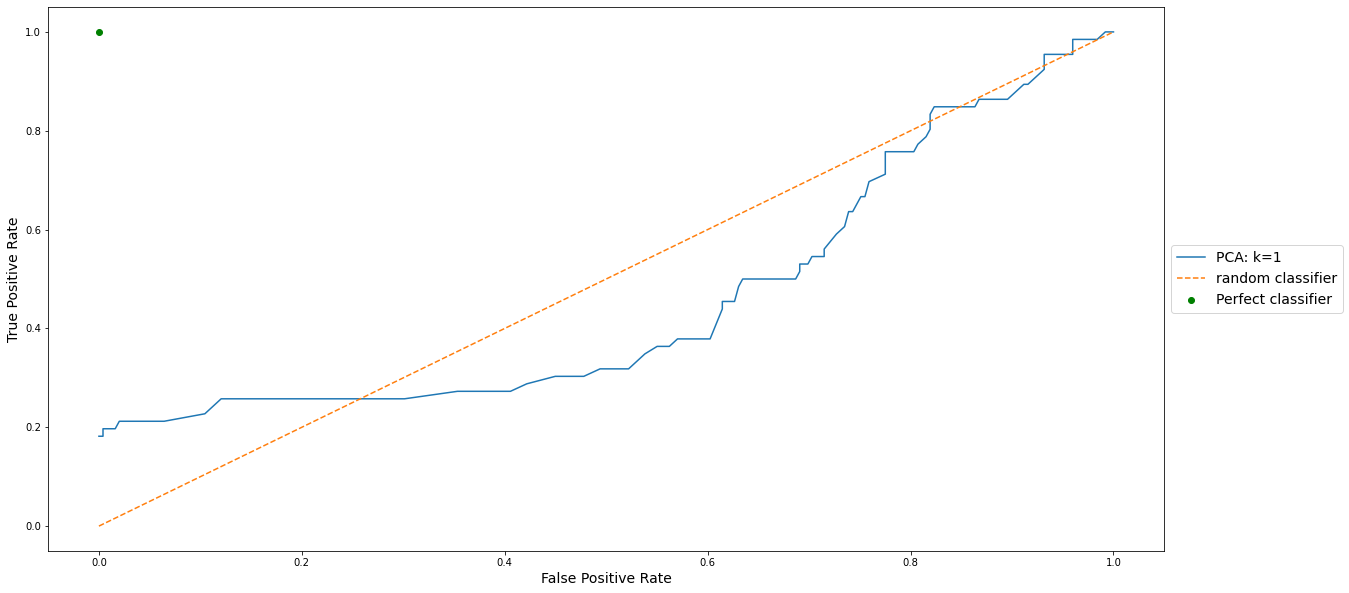

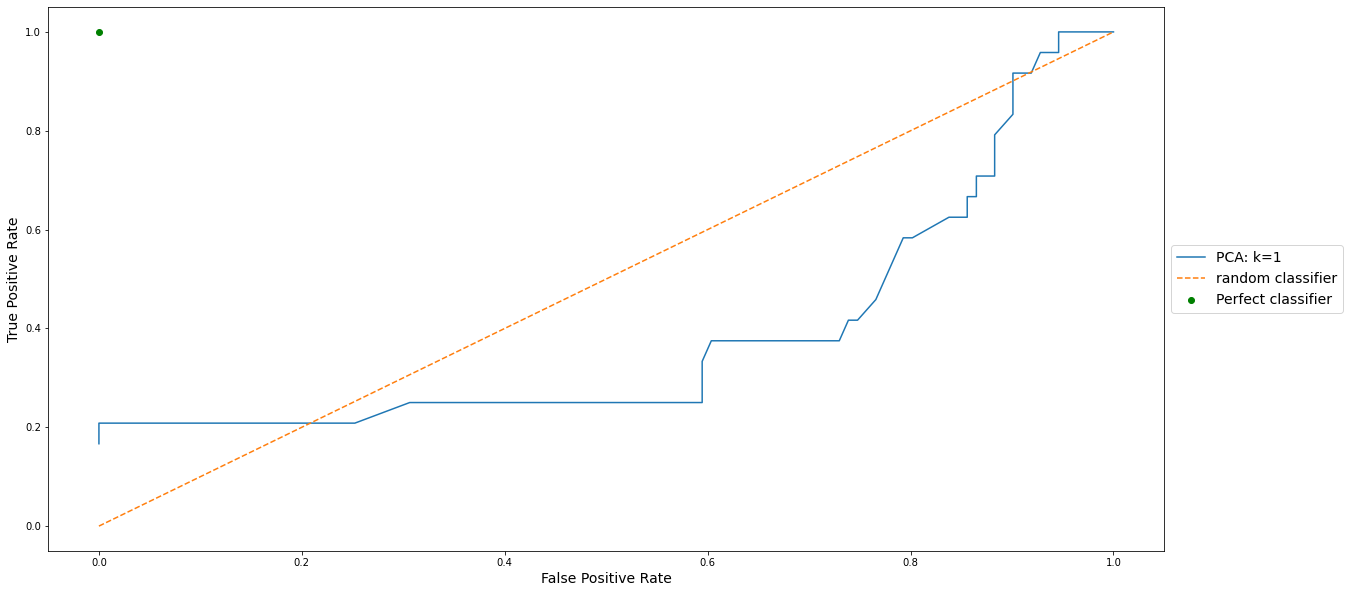

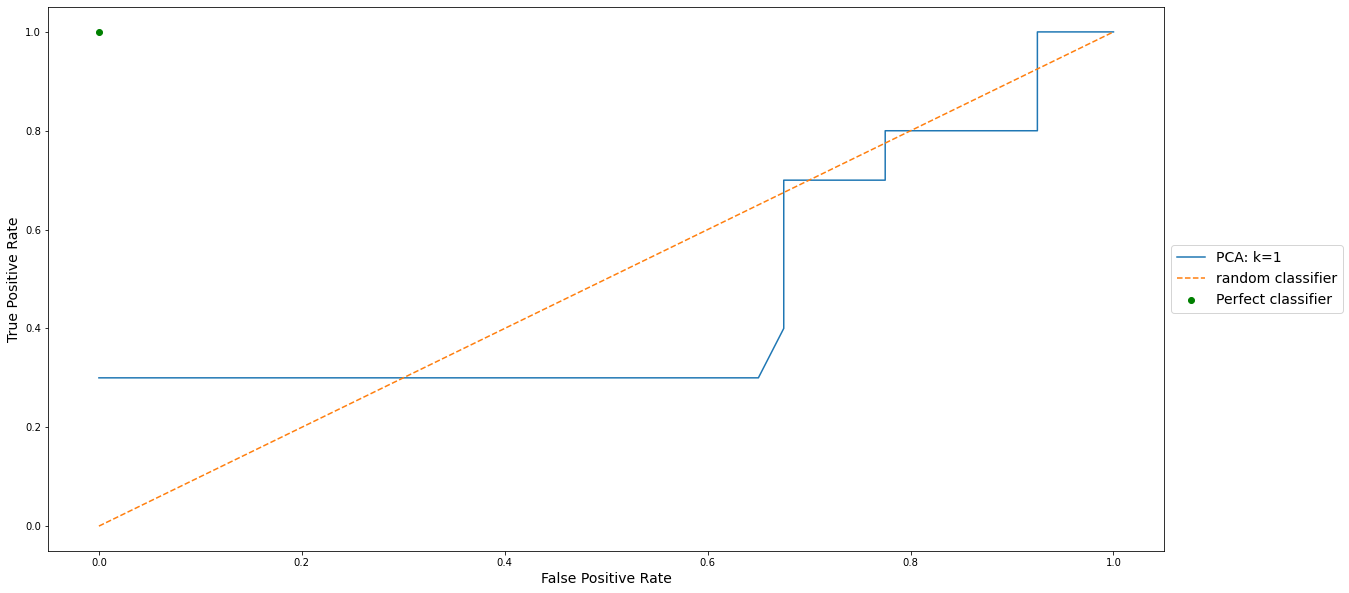

In [36]:
clf_pca = OutlierDetectorPCA(k=1)
clf_pca.fit(X_train, y_train)
clf_pca.predict(X_val)
clf_pca.predict(X_test)
print('Score in Train:', clf_pca.score(X_train, y_train))
print('Score in Val set:', clf_pca.score(X_val, y_val))
print('Score in test set:', clf_pca.score(X_test, y_test))

plot_ROC(clf_pca.fit(X_train, y_train), X_train, y_train)
plot_ROC(clf_pca.fit(X_train, y_train), X_val, y_val)
plot_ROC(clf_pca.fit(X_train, y_train), X_test, y_test)

# Q4 : k-pca

<font size=5 color=#009999> Q4. k-PCA </font> <br>
</font>

Let us implement an outlier detector using <b>k-PCA</b>.
We can now leverage the work we did by defining a class in Q3: we "cheat" by <b>computing the features of the feature space</b> and then applying standard PCA on it.

We implemented most of the class, but there are some parts missing...

<div class="alert alert-warning">
    <b>[Remark]</b> We <b>could</b> implement kPCA without resorting to the explicit computation of the features $\phi(\mathbf{x}_i)$, but the implementation is a bit tricky...

This works here because the data set is not large, both in terms of input space (2-dimensional) and in the number of samples.
    
Remark that even with higher dimensional data set, we could simply restrict ourself to k' (principal) components, and computing the projection onto $\mathcal{S}_k$ with k << k'.
    
It would be interesting for you to take advantage of this to <i>actually see what features in the feature space look like</i>.
    
</div>

In [37]:
class OutlierDetectorKPCA(OutlierDetectorPCA):
    def __init__(self, param, k):
        """ ------------------------------------------------------------------------------
        Class constructor
        INPUT:
            - param: a dictionary containing the params of the kernel pca
            - k: the number of eigenvectors that we keep, or equivalently, the size of the
                 the eigen (sub)space.
        Example of the use of the constructor
            
            clf_kpca = OutlierDetectorKPCA(param={'kernel':'rbf', 'gamma':42}, k=1)
        ------------------------------------------------------------------------------ """
        OutlierDetectorPCA.__init__(self, k)  # we take advantage of the inheritance
        self.kpca = KernelPCA(fit_inverse_transform=False, remove_zero_eig=False)
        self.name = 'KPCA'
        self.params = param
        self.kpca.set_params(**param)
        #print("Params", self.kpca.get_params())

    def _predict_tau_ROC(self, X, tau):
        """ ------------------------------------------------------------------------------
        Companion function used to properly deal with the ROC of this inherited class
        ------------------------------------------------------------------------------ """                
        X_kpca = self.kpca.transform(X)
        return OutlierDetectorPCA.predict_tau(self, X_kpca, tau)        
        
        
    def fit(self, X, y):
        """ ------------------------------------------------------------------------------
        Fit the model to the true data
        INPUT: 
            - X: training data
            - y: label of training data
        OUTPUT:
            - the classifier
        ------------------------------------------------------------------------------ """
        #print("X shpae: " + str(X.shape))
        X_kpca = self.kpca.fit_transform(X)
        #print("print k pca")
        #print(X_kpca)
        #print("kpca shape: "+ str(X_kpca.shape))
        return OutlierDetectorPCA.fit(self, X_kpca, y)
        

        
    def get_label(self):
        label = OutlierDetectorPCA.get_label(self) + ", gamma={gamma}, kernel={kernel}".format(
            gamma=self.params['gamma'],
            kernel=self.params['kernel'])
        return label


        
    def predict(self, X):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model
        INPUT: 
            - X: data
        OUTPUT:
            - y: predictions
        ------------------------------------------------------------------------------ """        
        # TODO
        check_is_fitted(self)
        
        X_kpca = self.kpca.transform(X) 
        #print("kpca shape:"+ str(X_kpca.shape))
        X_hat_kpca = X_kpca[:,:self.k]
        #print(len(X_hat_kpca))
        #print("hat KPCA:")
        #print(X_hat_kpca)
        #print("X_hat_kpca shape:"+ str(X_hat_kpca.shape))
        rec_error = OutlierDetectorPCA._get_recons_error(self,X_kpca,X_hat_kpca)
        #print("10 first errors in KPCA: " + str(rec_error[:10]))

        y_pred = []
        for e in rec_error: 
            if(e>self.tau):
                y_pred.append(1)
            else:
                y_pred.append(0)   
        
        # y_pred = np.ones(X.shape[0])
        return y_pred
    

        

nb of detected outliers in validation set: 0


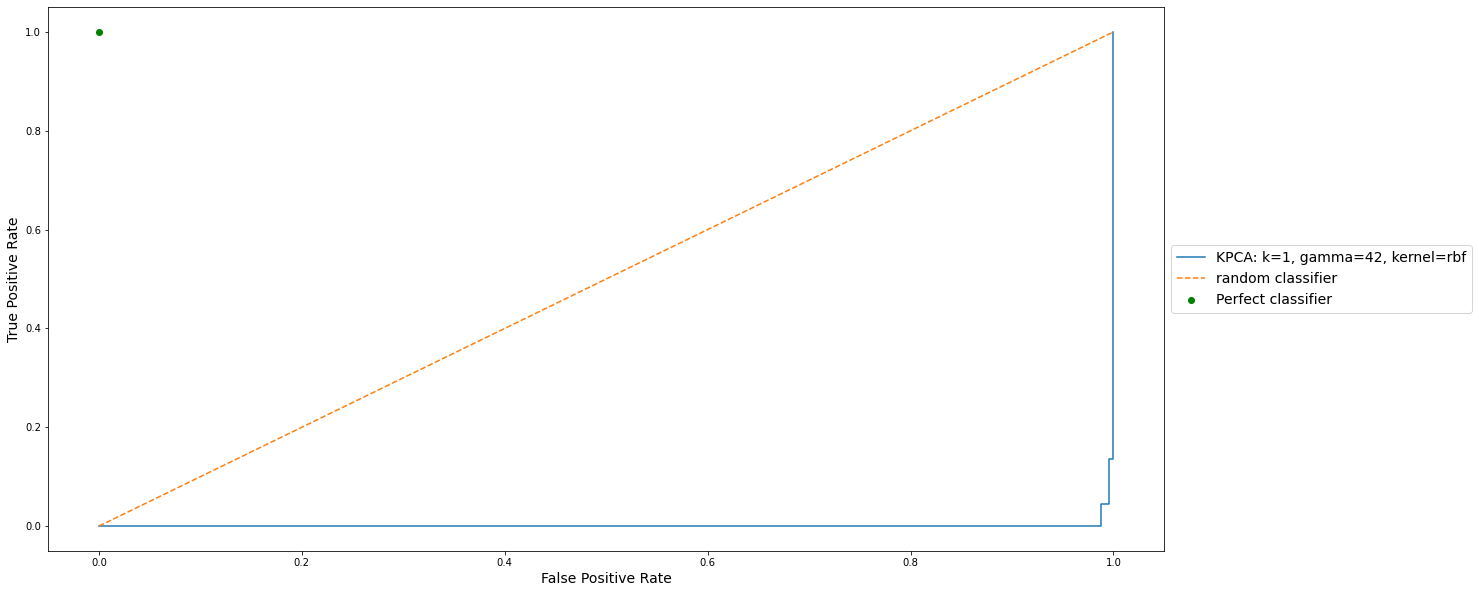

In [38]:
# TODO: you may test here your implementation of the class OutlierDetectorPCA

stupid_clf_kpca = OutlierDetectorKPCA(param={"kernel":"rbf", "gamma":42} , k=1)

#fitted_kpca_clsf = clf_kpca.fit(X_train, y_train)

stupid_clf_kpca.fit(X_train, y_train)

print("nb of detected outliers in validation set: "+ str(sum(stupid_clf_kpca.predict(X_val))))

#K_x = clf_kpca.transform(X_val)
#print("dim: "+ str(K_x))
stupid_clf_kpca.score(X_val,y_val)
#plot_ROC(clf_kpca, X_val, y_val, file_name=None)
plot_ROC(stupid_clf_kpca, X_train, y_train)

# Q5 : Model selection

<font size=5 color=#009999> Q5. Model selection </font> <br>
</font>

Perform your model selection: don't forget that you train your models on the train set, and tune the hyperparameter using the validation set.


In [39]:
# TODO: Model selection

components = [1,5,10,50]
kernel = ['poly', 'rbf']
gammas = [0.001, 0.01,1,10,100]

params = {"kernel":"rbf", "gamma":42}
best_score= 0
best_m = {'comp':0, 'kern': 'yo', 'gamma': 4}

for c in components:
    for k in kernel:
        for g in gammas:
            params = {"kernel":k, "gamma":g}
            kpca_clas = OutlierDetectorKPCA(param=params , k=c)
            fitted_clas = kpca_clas.fit(X_train,y_train)
            cur_score = kpca_clas.score(X_val,y_val)
            if cur_score > best_score:
                best_score = cur_score
                best_m['comp'] = c 
                best_m['kern'] = k
                best_m['gamma']= g

print("best model: " + str(best_m))
print("accuracy of best model:" + str(best_score))




best model: {'comp': 5, 'kern': 'rbf', 'gamma': 0.01}
accuracy of best model:0.8592592592592593


predict test


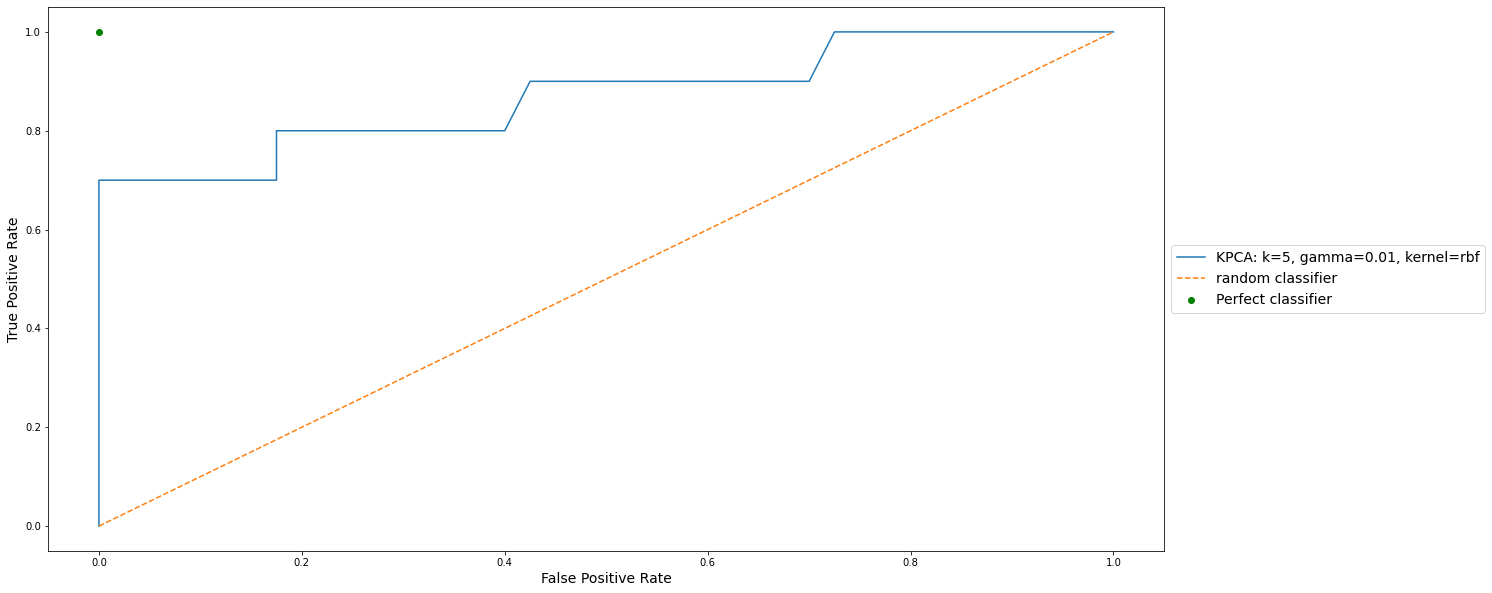

In [41]:
kpca_best_params = {"kernel": best_m['kern'], "gamma":best_m['gamma']}
final_kpca_model = OutlierDetectorKPCA(param= kpca_best_params, k=best_m['comp'])

final_kpca_model.fit(X_train,y_train)
print("predict test")
final_kpca_model.predict(X_test)

plot_ROC(final_kpca_model, X_test, y_test)


<font size=4 color=#009999> Plot the results </font> <br>
</font>

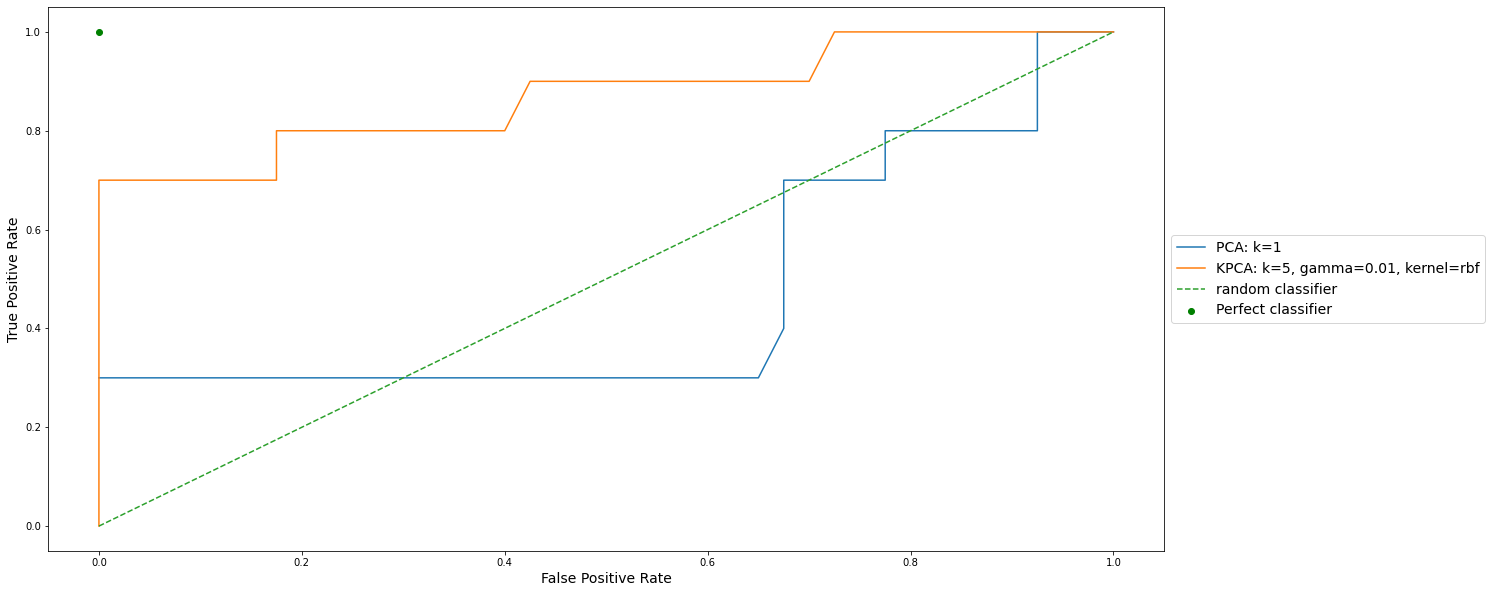

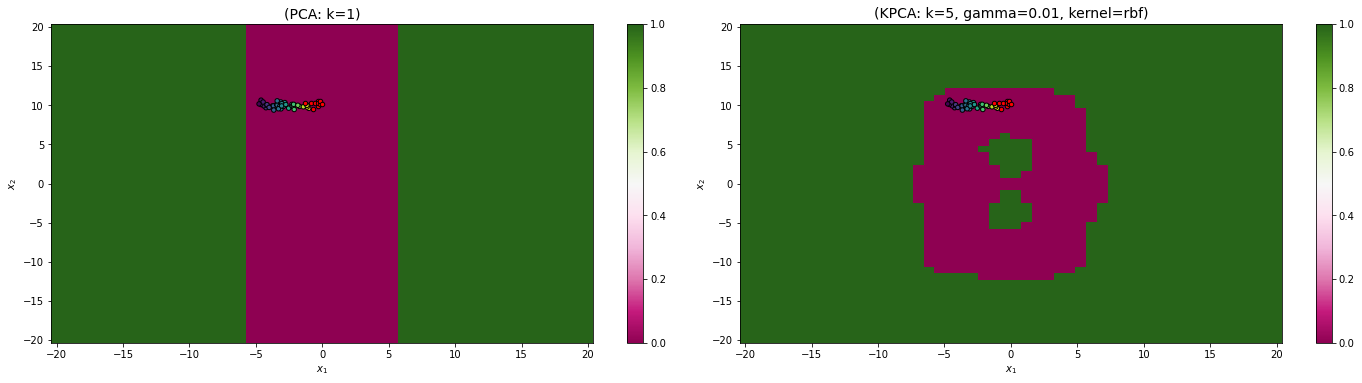

In [42]:
classifs = [clf_pca,final_kpca_model] # list of the model I want to compare

plot_ROC(classifs, X_test, y_test, file_name="plot_comparison_outlier_detector")
plot_comparison_outlier_detector(classifs, X_test, y_test)

# Q6 : Analysis

<font size=5 color=#009999> Q6. Analysis </font> <br>
</font>

In [43]:
print(final_kpca_model.score(X_train, y_train))
print(final_kpca_model.score(X_test,y_test))

0.8317460317460318
0.88


<h1><center>LINMA2472 : Porject 2, part 2, Random Fourier Features </center></h1>

Remi Delogne, remi.delogne@uclouvain.be

Import the following packages and functions. Refer to their documentation on the internet for more information on installation and usage.

In [1]:
!pip install keras
!pip install tensorflow

In [2]:
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

from keras.datasets import mnist #Contains the dataset
from matplotlib import pyplot

import time #Used to find the execution time of a part of the code

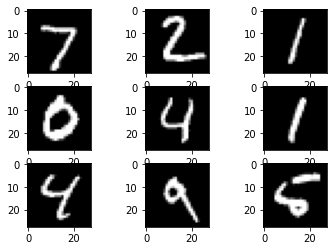

(10000, 28, 28)
(10000, 784)


In [3]:
# load dataset and rescale the data to [0,15]
''' load dataset: (we use the larger subset for testing and the smaller 
for training to demonstrate the efficiency of evaluation of new instances)'''
(testX,testy),(trainX,trainy) = mnist.load_data()

#Rescaling
trainX = np.floor(trainX/16)
testX = np.floor(testX/16)

#Plot some images, for fun
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print(trainX.shape)
#Put the data in vector form
trainX=trainX.reshape((10000,-1))
testX=testX.reshape((60000,-1))
print(trainX.shape)

In [4]:
#Example of timing a piece of code
tik=time.perf_counter() # Start addedd
for i in range (10000):
     i=i+1
tok=time.perf_counter() # Finish added
print('Total time: %s' % (tok-tik))

Total time: 0.0010950560000004828


### Train a linear SVM on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the method takes to evaluate the 60.000 testing instances

Use the accuracy metric to judge the quality of your classifier

In [5]:
#Define the classifier
clfLin=svm.SVC(kernel="linear")
#Train the classifier
clfLin.fit(trainX,trainy)

#Evaluate its accuracy
tik=time.perf_counter() # Start added
predicted=clfLin.predict(testX)
tok=time.perf_counter() # Finish added
print('Total time for the : %s' % (tok-tik))

score=accuracy_score(testy,predicted)
print('Accuracy:%s' % (score))

Total time for the : 54.53727347
Accuracy:0.90665


### Train a Kernel SVM with the Gaussian Kernel on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the method takes to evaluate the $60000$ testing instances

Use the accuracy metric to judge the quality of your classifier

You may stick to the default parameters of sci-kit learn

In [6]:
#Define the classifier
clfKernel=svm.SVC(kernel='rbf')
#Train it
clfKernel.fit(trainX, trainy)
#Use it
tik=time.perf_counter() # Start added
predicted=clfKernel.predict(testX)
tok=time.perf_counter() # Finish added


print('Total time for the : %s' % (tok-tik))
score=accuracy_score(testy,predicted)
print('Accuracy: %s' % (score))

Total time for the : 136.14753549
Accuracy: 0.9560833333333333


### Use the following functions to implement Random Fourier Features

Use the first function to generate your $\boldsymbol\omega_i$ and $b_i$

Use the second function to create the mapping $\boldsymbol z(\boldsymbol x)$ as described in the slides.

In [7]:
def generate_freq(D: int, d: int, sd: float):
    W = []
    for i in range(D):
        W.append(np.random.normal(loc = 0,scale = 0.01, size = d))
    b = np.random.uniform(low = 0, high = 2 *np.pi, size = D) # pas D ???
    W = np.array(W)
    return W,b

def rff_gaussian2(x: np.ndarray, W, b):
    D = len(W)
    W_x_transpo = (x @ W.transpose()).transpose()
    for i in range(len(b)):
        W_x_transpo[i:] += b[i]
    Z = np.sqrt(2/D) * np.cos( W_x_transpo ).transpose()
    return Z

### Transform your trainX and testX

Use the function you defined to transform your data

Make sure you only generate $\boldsymbol W$ and $\boldsymbol b$ once

Use $\sigma=100$ and $D=300$

You may also use the tik-tok method to time the procedure of creating Random features

In [8]:
W,b = generate_freq(300, len(trainX[0]),100)

tik=time.perf_counter() # Start added
trainX_fourier=rff_gaussian2(trainX, W, b)
testX_fourier=rff_gaussian2(testX, W, b)
tok=time.perf_counter() # Finish added

In [9]:
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=np.inf)

#Train it
clfRff.fit(trainX_fourier, trainy)

#Use it
predicted = clfRff.predict(testX_fourier)
score = accuracy_score(testy,predicted)
print('Accuracy: %s' % (score))

Accuracy: 0.8944166666666666


### Additional workspace 

Testing the accuracy for different values of $D$.

In [ ]:
trainX_sub = trainX[0:1000:]
trainy_sub = trainy[0:1000:]

TestX_sub = testX[0:1000:]
testy_sub = testy[0:1000:]


accuracy=[]


to_test = [50,100,200,300,400,500]
for i in range(6):
    
    D=to_test[i]
    W,b = generate_freq(len(trainX[0]), D,1/100)
    trainX_fourier=rff_gaussian2(trainX_sub, W, b)
    testX_fourier=rff_gaussian2(TestX_sub, W, b)
        
    clfLin=svm.SVC(kernel="linear")
    clfLin.fit(trainX_fourier,trainy_sub)
    
    predicted=clfLin.predict(testX_fourier)
    
    acc=accuracy_score(testy_sub,predicted)
    accuracy.append(acc)
for i in range(6):
    print("D("+ str(to_test[i]) + ": D" + str(accuracy[i]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 784)